In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec

from dataclasses import dataclass
from typing import Dict
from scipy import spatial, stats
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [184]:
def euclidean_similarity(x,y):
    return 1/(1+euclidean_distances(x,y))

# Fig 1: Per Pair Analysis

In [185]:
def replace_phenomenon_names(df):
    # Replace phenomenon names
    phenomenon_names = []
    for _, row in df.iterrows():
        if row["phenomenon_name"] in ("Premise Diversity", "Premise Monotonicity"):
            name = f"{row['phenomenon_name']} ({row['phenomenon_type']})"
        else:
            name = row["phenomenon_name"]
        name = name.replace(" ", "\n").replace("-c", "\nC")
        phenomenon_names.append(name)
    return phenomenon_names

PHENOMENON_NUMBER_TO_NAME = {
    1: "Premise Typicality",
    2: "Premise Diversity (General)",
    3: "Conclusion Specificity",
    4: "Premise Monotonicity (General)",
    5: "Premise-conclusion Similarity",
    6: "Premise Diversity (Specific)",
    7: "Premise Monotonicity (Specific)",
    8: "Premise-conclusion Asymmetry",
    9: "Nonmonotonicity (General)",
    10: "Nonmonotonicity (Specific)",
    11: "Inclusion Fallacy",
}

PHENOMENON_ORDER = {
    "Premise-conclusion Similarity": 1,
    "Premise Typicality": 2,
    "Conclusion Specificity": 3,
    "Premise Monotonicity (General)": 4,
    "Premise Monotonicity (Specific)": 5,
    "Premise Diversity (General)": 6,
    "Premise Diversity (Specific)": 7,
    "Nonmonotonicity (General)": 8,
    "Nonmonotonicity (Specific)": 9,
    "Premise-conclusion Asymmetry": 10,
    "Inclusion Fallacy": 11,
}

GPT3_RESPONSES = "../osherson_phenomena_final_synthetic_instruct.csv"

In [186]:
# Get human responses for Osherson set

human_ratings_rows = []
hdf = pd.read_csv("../data/osherson_phenomena.csv", index_col=0)
hdf["select_prob"] = [hv / 80 for hv in hdf["human_votes"]]
for phenomenon_number, pdf in hdf.groupby("phenomenon_number"):
    human_ratings_rows.append((PHENOMENON_NUMBER_TO_NAME[phenomenon_number].replace(" ", "\n"), phenomenon_number, "human", pdf[pdf["stronger"]]["select_prob"].iloc[0] / np.sum(pdf["select_prob"])))
human_ratings_df = pd.DataFrame(human_ratings_rows, columns=["phenomenon", "phenomenon_number", "agent", "win_prob"])

# Get GPT-3 responses for Osherson set

gpt3_ratings_rows = []
odf = pd.read_csv("../osherson_phenomena_final_osherson_instruct.csv", index_col=0).fillna("")
odf["phenomenon"] = replace_phenomenon_names(odf)
odf["sample_type"] = ["strong", "weak"] * int(odf.shape[0]/2)
odf["yes_prob"] = [np.exp(ylp) for ylp in odf["yes_logprob"]]
odf["no_prob"] = [np.exp(ylp) for ylp in odf["no_logprob"]]
odf["yes_prob"] = odf["yes_prob"] / (odf["yes_prob"] + odf["no_prob"])
for phenomenon_number, pdf in odf.groupby("phenomenon_number"):
    gpt3_ratings_rows.append((PHENOMENON_NUMBER_TO_NAME[phenomenon_number].replace(" ", "\n"), phenomenon_number, "gpt-3", pdf[pdf["sample_type"] == "strong"]["yes_prob"].iloc[0] / np.sum(pdf["yes_prob"])))
gpt3_ratings_df = pd.DataFrame(gpt3_ratings_rows, columns=["phenomenon", "phenomenon_number", "agent", "win_prob"])

# Get GPT-3 responses for artificial set

gpt3_artificial_rating_rows = []
adf = pd.read_csv(GPT3_RESPONSES, index_col=0).fillna("")
adf["phenomenon"] = replace_phenomenon_names(adf)
adf["sample_type"] = ["strong", "weak"] * int(adf.shape[0]/2)
adf["yes_prob"] = [np.exp(ylp) for ylp in adf["yes_logprob"]]

adf["no_prob"] = [np.exp(ylp) for ylp in adf["no_logprob"]]
adf["yes_prob"] = adf["yes_prob"] / (adf["yes_prob"] + adf["no_prob"])

for phenomenon_number, pdf in adf.groupby("phenomenon_number"):
    for i in range(int(pdf.shape[0]/2)):
        select_prob = pdf.iloc[i*2]["yes_prob"] / (pdf.iloc[i*2]["yes_prob"] + pdf.iloc[i*2+1]["yes_prob"])
        sp1, sp2, sp3, sc = pdf.iloc[i*2][["premise_category_1", "premise_category_2", "premise_category_3", "conclusion_category"]].values
        wp1, wp2, wp3, wc = pdf.iloc[i*2+1][["premise_category_1", "premise_category_2", "premise_category_3", "conclusion_category"]].values
        gpt3_artificial_rating_rows.append((PHENOMENON_NUMBER_TO_NAME[phenomenon_number].replace(" ", "\n"), phenomenon_number, "gpt-3", select_prob, sp1, sp2, sp3, sc, wp1, wp2, wp3, wc))
gpt3_artificial_ratings_df = pd.DataFrame(gpt3_artificial_rating_rows, columns=["phenomenon", "phenomenon_number", "agent", "win_prob", "sp1", "sp2", "sp3", "sc", "wp1", "wp2", "wp3", "wc"])

# Sort
for tdf in (human_ratings_df, gpt3_ratings_df, gpt3_artificial_ratings_df):
    tdf["phenomenon_order"] = [PHENOMENON_ORDER[p.replace("\n", " ")] for p in tdf["phenomenon"]]
human_ratings_df = human_ratings_df.sort_values(by="phenomenon_order")
gpt3_ratings_df = gpt3_ratings_df.sort_values(by="phenomenon_order")
gpt3_artificial_ratings_df = gpt3_artificial_ratings_df.sort_values(by="phenomenon_order")

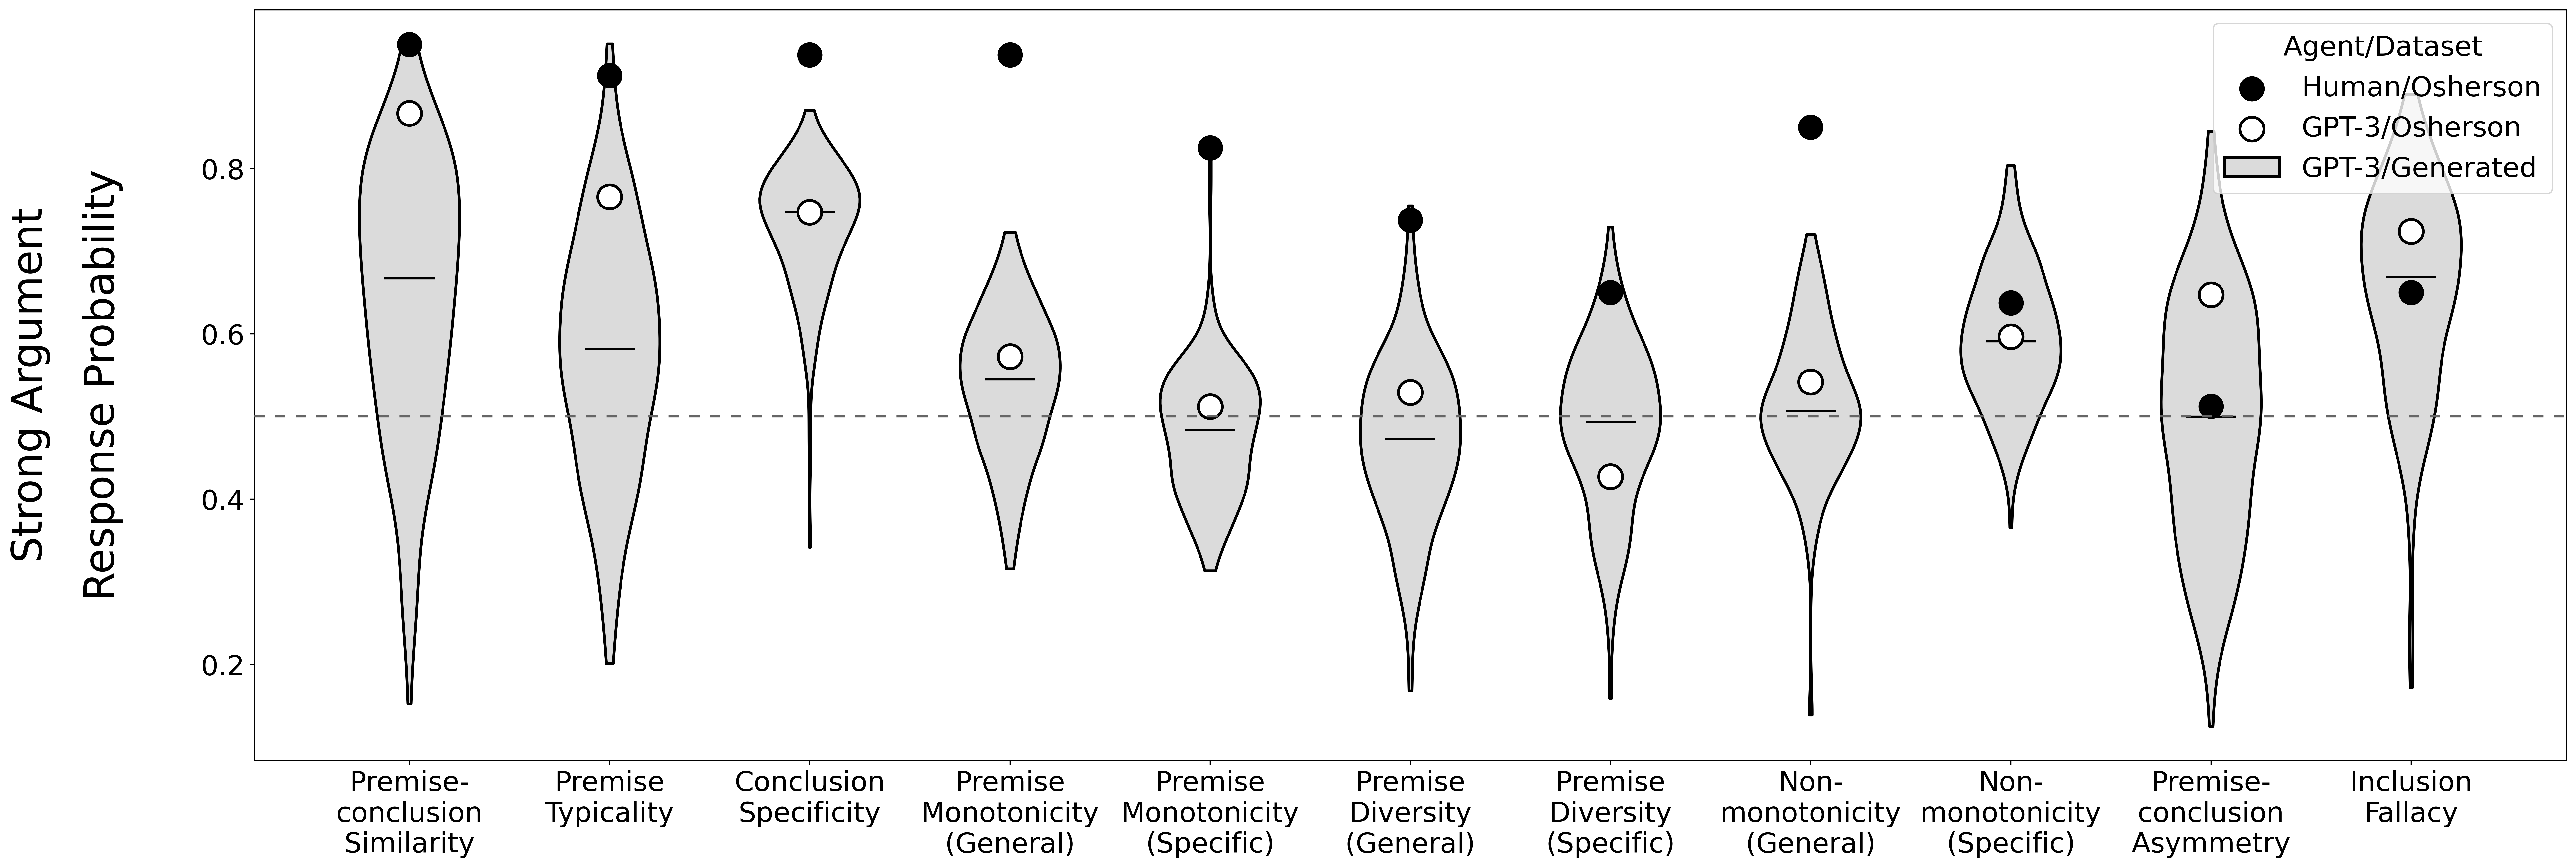

In [187]:
# Add a little bit to the asymmetry gpt3 prob so that it's visible
#gpt3_ratings_df["win_prob"] = [row["win_prob"] + 0.005 if row["phenomenon_number"] == 8 else row["win_prob"] for _, row in gpt3_ratings_df.iterrows()]

# Func to draw line segment
def newline(p1, p2):
    ax = plt.gca()
    l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='#4d4d4d', linewidth=0, zorder=2)
    ax.add_line(l)
    return l

fig, ax = plt.subplots(1,1,figsize=(30,10), dpi= 400)

# Line Segments
for i, p1, p2 in zip(human_ratings_df["phenomenon_order"], human_ratings_df["win_prob"], gpt3_ratings_df["win_prob"]):
    newline([i, p1], [i, p2])

# Points
s1 = ax.scatter(x=human_ratings_df["phenomenon_order"], y=human_ratings_df["win_prob"], s=300, color='#000000', alpha=1, zorder=3)
s2 = ax.scatter(x=gpt3_ratings_df["phenomenon_order"], y=gpt3_ratings_df["win_prob"], s=300, color='#ffffff', edgecolors='#000000', linewidths=2, alpha=1, zorder=3)

# Violins
violin_parts = ax.violinplot(dataset=[tdf["win_prob"] for pn, tdf in gpt3_artificial_ratings_df.groupby("phenomenon_order")], vert=True, showmedians=True, showextrema=False)
for pc in violin_parts['bodies']:
    pc.set_alpha(1)
    pc.set_color('#dbdbdb')
    pc.set_edgecolor('#000000')
    pc.set_linewidth(2)
violin_parts["cmedians"].set_color('#000000')
violin_parts["cmedians"].set_snap(True)

# Horizontal dashed line at 0.5
ax.axhline(y=0.5, dashes=(5,5), color='#666666', zorder=4)

# Labels and titles
ax.set_xticks(list(range(1,12)))
ax.set_xticklabels([p.replace("-", "-\n").replace("Non", "Non-\n") for p in gpt3_ratings_df["phenomenon"].tolist()])
#ax.set_xlabel("\nPhenomenon", linespacing=2, fontsize=30)
ax.set_ylabel("Strong Argument\nResponse Probability\n", linespacing=2, fontsize=30)

# Readability 
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Legend
ax.legend([s1, s2, violin_parts["bodies"][0]], ['Human/Osherson', 'GPT-3/Osherson', 'GPT-3/Generated'], title="Agent/Dataset", title_fontsize=20, fontsize=20)

plt.savefig("fig1", dpi=600)

# Fig 2: GPT-SCM/Human Correlation

In [102]:
# Get embeddings
embedding_df = pd.read_csv("../data/kempleuven_category_embeddings.csv", index_col=0)
embedding_df["embedding"] = embedding_df["embedding"].apply(eval).apply(np.array)
category2embedding = pd.Series(embedding_df["embedding"].tolist(), index=embedding_df["category"].tolist()).to_dict()
categories = embedding_df["category"].tolist()

In [103]:
CATEGORY_HIERARCHY = {
    "Animal": 3,
    "Mammal": 2,
    "Bird": 2,
    "Fish": 2,
    "Reptile": 2,
    "Insect": 2,
}

CLASS_LISTS = {
    "Mammal": categories[1:31],
    "Bird": categories[32:62],
    "Fish": categories[63:86],
    "Reptile": categories[114:-1],
    "Insect": categories[87:113],
}

PREMISE_NUMBERS = {
    1:"horse",
    2:"cow",
    3:"chimp",
    4:"gorilla",
    5:"mouse",
    6:"squirrel",
    7:"dolphin",
    8:"seal",
    9:"elephant",
    10:"rhino",
}

def get_category_class(category):
    for k,v in CLASS_LISTS.items():
        if category.capitalize() in v:
            return k
    return category.capitalize()

def get_category_hierarchy(category):
    if category in CATEGORY_HIERARCHY:
        return CATEGORY_HIERARCHY[category]
    else:
        return 1
        
def scm(premise_1, premise_2, premise_3, conclusion, category2embedding, alpha=0.25) -> float:
    
    if conclusion in PREMISE_NUMBERS.values():
        conclusion_categories = [conclusion]
    else:
        conclusion_categories = list(PREMISE_NUMBERS.values())
        
    a = np.mean([
        np.max([
            cosine_similarity([category2embedding[p]], [category2embedding[c_cat]])[0][0]
            for p in [premise_1, premise_2, premise_3] if p
        ])
        for c_cat in conclusion_categories
    ])
        
    # calculate b
    conclusion_categories = list(PREMISE_NUMBERS.values())
    b = np.mean([
            np.max([
                cosine_similarity([category2embedding[p]], [category2embedding[c_cat]])[0][0]
                for p in [premise_1, premise_2, premise_3] if p
            ])
            for c_cat in conclusion_categories
    ]) 
    
    return alpha*a + (1-alpha)*b

def get_human_strength_df(conclusion_type):
    df = pd.read_csv(f"../data/structstat_{conclusion_type}_arguments_gpt_instruct.csv", index_col=0)
    df["yes_prob"] = [np.exp(ylp) for ylp in df["yes_logprob"]]
    df["no_prob"] = [np.exp(ylp) for ylp in df["no_logprob"]]
    df["yes_prob"] = df["yes_prob"] / (df["yes_prob"] + adf["no_prob"])

    # Load human strength ratings
    if conclusion_type == "specific":
        human_strength_columns = ["premise_1", "premise_2", "conclusion", "human strength"]
    else:
        human_strength_columns = ["premise_1", "premise_2", "premise_3", "human strength"]
    human_strength_df = pd.read_csv(f"../data/structstat/{conclusion_type}arguments.txt", sep="   ", names=human_strength_columns, engine="python")
    for col in human_strength_columns[:-1]:
        human_strength_df[col] = human_strength_df[col].apply(int).apply(lambda x: PREMISE_NUMBERS[x])
    
    # Load embeddings
    embeddings = pd.read_csv("../data/structstat_embeddings.csv", index_col=0)
    embeddings["embedding"] = embeddings["embedding"].apply(eval).apply(np.array)
    category2embedding = pd.Series(embeddings["embedding"].tolist(), index=embeddings["category"].tolist()).to_dict()

    # Calculate SCM scores
    if conclusion_type == "specific":
        human_strength_df["gpt maxsim scm"] = [scm(row["premise_1"], row["premise_2"], "", row["conclusion"], category2embedding) for _, row in human_strength_df.iterrows()]
    else:
        human_strength_df["gpt maxsim scm"] = [scm(row["premise_1"], row["premise_2"], row["premise_3"], "all mammals", category2embedding, alpha=0.95) for _, row in human_strength_df.iterrows()]
        
    return df, human_strength_df

Text(0.05, 0.05, 'r=0.49, p<0.01')

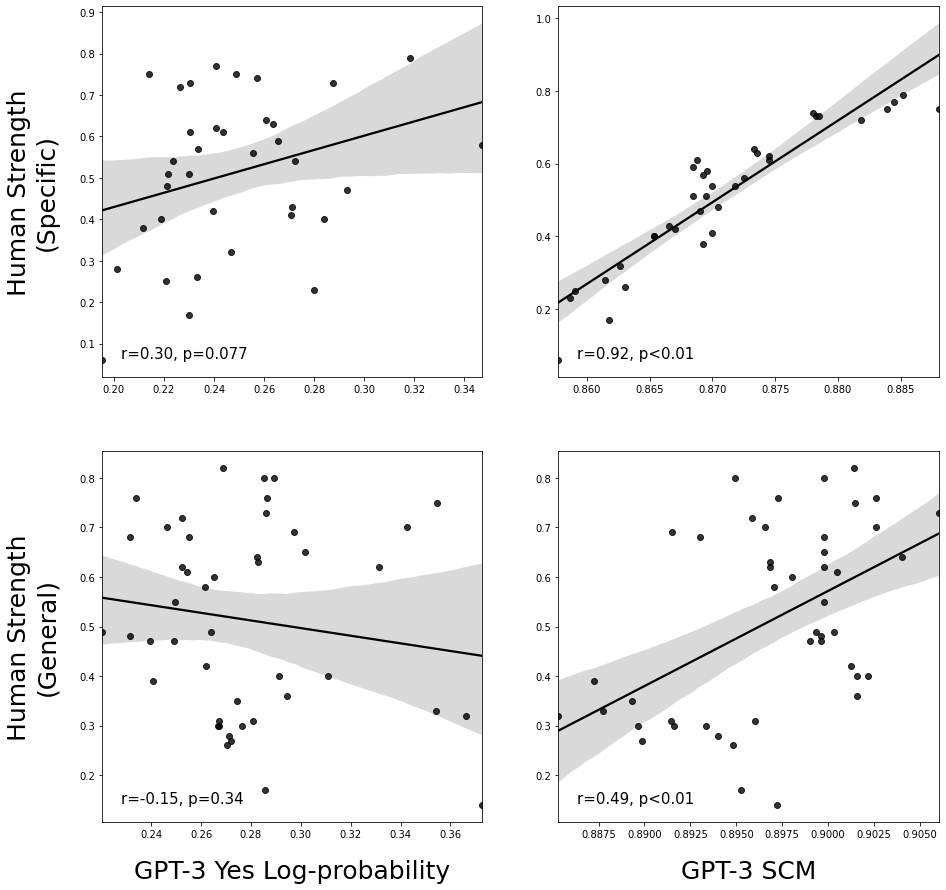

In [104]:
# Load GPT-3 yes probabilities
specific_df, specific_human_strength_df = get_human_strength_df("specific")
general_df, general_human_strength_df = get_human_strength_df("general")
    
fig, axes = plt.subplots(2,2,figsize=(15,15))
sns.regplot(y=specific_human_strength_df["human strength"], x=specific_df["yes_prob"], ax=axes[0][0], scatter_kws={"color": "black"}, line_kws={"color": "black"})
sns.regplot(y="human strength", x="gpt maxsim scm", data=specific_human_strength_df, ax=axes[0][1], scatter_kws={"color": "black"}, line_kws={"color": "black"})

sns.regplot(y=general_human_strength_df["human strength"], x=general_df["yes_prob"], ax=axes[1][0], scatter_kws={"color": "black"}, line_kws={"color": "black"})
sns.regplot(y="human strength", x="gpt maxsim scm", data=general_human_strength_df, ax=axes[1][1], scatter_kws={"color": "black"}, line_kws={"color": "black"})

axes[0][0].set_ylabel('Human Strength\n(Specific)', labelpad=20, fontsize=25)
axes[1][0].set_ylabel('Human Strength\n(General)', labelpad=20, fontsize=25)

for i in range(2):
    for j in range(2):
        plt.setp(axes[i][j].get_xticklabels(), fontsize=10)
        plt.setp(axes[i][j].get_yticklabels(), fontsize=10)

axes[0][0].set_xlabel('')
axes[0][1].set_xlabel('')
axes[1][0].set_xlabel('GPT-3 Yes Log-probability', labelpad=20, fontsize=25)
axes[1][1].set_xlabel('GPT-3 SCM', labelpad=20, fontsize=25)
for i in range(2):
    axes[i][1].set_ylabel('')

r, p = stats.pearsonr(specific_df["yes_prob"], specific_human_strength_df["human strength"])
axes[0][0].text(.05, .05, 'r={:.2f}, p={:.2g}'.format(r, p), fontsize=15, transform=axes[0][0].transAxes)
r, p = stats.pearsonr(specific_human_strength_df["human strength"], specific_human_strength_df["gpt maxsim scm"])
axes[0][1].text(.05, .05, 'r={:.2f}, p<0.01'.format(r), fontsize=15, transform=axes[0][1].transAxes)

r, p = stats.pearsonr(general_df["yes_prob"], general_human_strength_df["human strength"])
axes[1][0].text(.05, .05, 'r={:.2f}, p={:.2g}'.format(r, p), fontsize=15, transform=axes[1][0].transAxes)
r, p = stats.pearsonr(general_human_strength_df["human strength"], general_human_strength_df["gpt maxsim scm"])
axes[1][1].text(.05, .05, 'r={:.2f}, p<0.01'.format(r), fontsize=15, transform=axes[1][1].transAxes)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

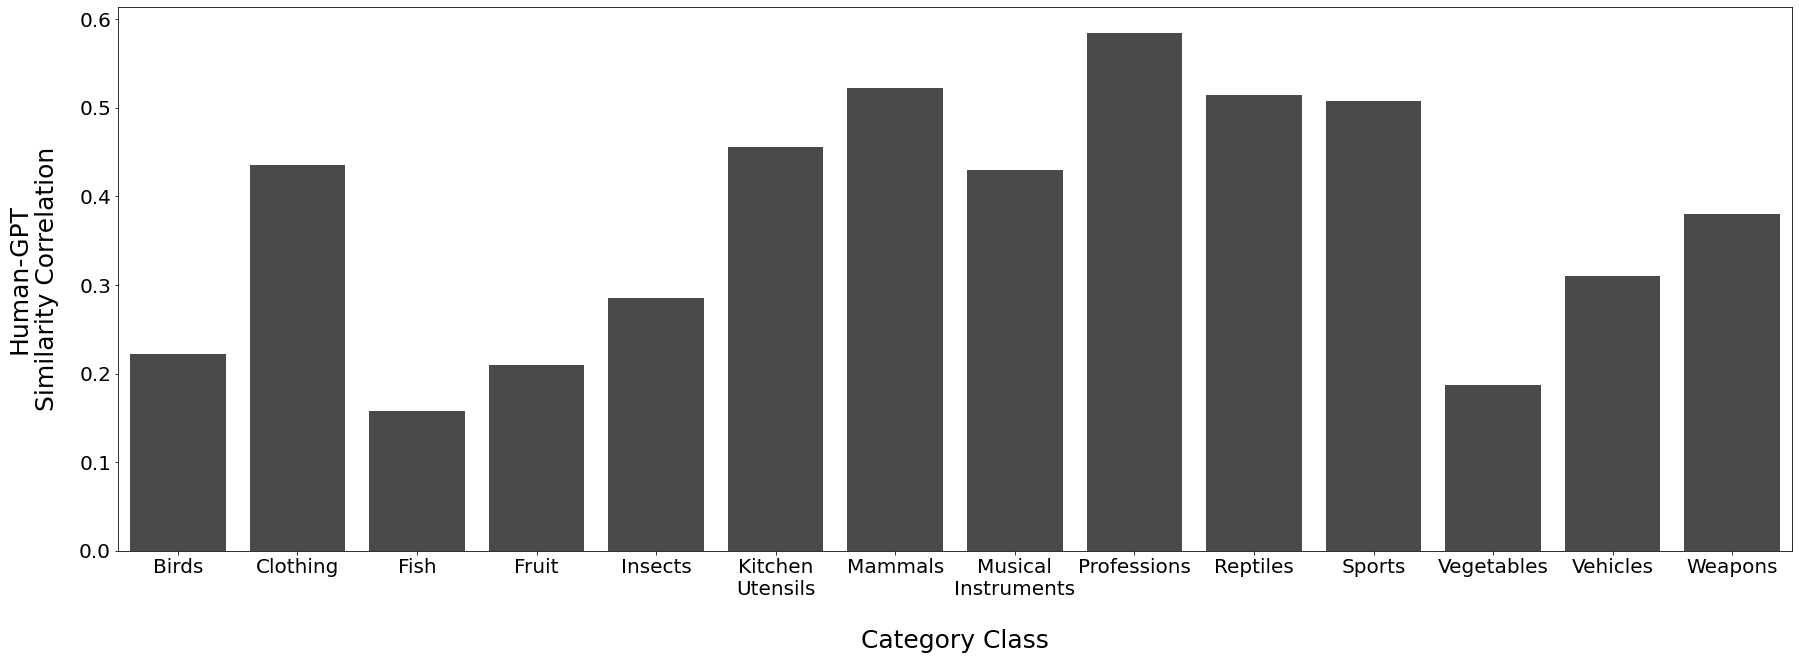

In [105]:
CLASSES = ["Birds", "Clothing", "Fish", "Fruit", "Insects", "KitchenUtensils", "Mammals", "MusicalInstruments", "Professions", "Reptiles", "Sports", "Vegetables", "Vehicles", "Weapons"]

@dataclass
class MatrixTranslationMixup:
    
    columns_are_switched: bool
    rows_are_switched: bool
        
mixups = {
    "Birds": MatrixTranslationMixup(False, True),
    "Clothing": MatrixTranslationMixup(False, True),
    "Fish": MatrixTranslationMixup(False, True),
    "Fruit": MatrixTranslationMixup(True,False),
    "Insects": MatrixTranslationMixup(False, False),
    "KitchenUtensils": MatrixTranslationMixup(False, False),
    "Mammals": MatrixTranslationMixup(False, False),
    "MusicalInstruments": MatrixTranslationMixup(False, True),
    "Professions": MatrixTranslationMixup(True, False),
    "Reptiles": MatrixTranslationMixup(False, False),
    "Sports": MatrixTranslationMixup(True, False),
    "Vegetables": MatrixTranslationMixup(True, False),
    "Vehicles": MatrixTranslationMixup(False, True),
    "Weapons": MatrixTranslationMixup(False, False),
}

def generate_similarity_df(category_class: str, mixups: Dict[str, MatrixTranslationMixup]) -> pd.DataFrame:
    
    folder = f"../data/de_deyne_pairwise/pairwiseSimilarities{category_class}"

    similarity_dfs = []
    for i in range(len(os.listdir(folder))):
        df = pd.read_csv(f"{folder}/pairwiseSimilarities{category_class}-{i+1}.csv", encoding = "ISO-8859-1")
        if mixups[category_class].columns_are_switched:
            df.columns = df.columns.tolist()[:2] + df.iloc[0,2:].tolist()
        if mixups[category_class].rows_are_switched:
            df["exemplar ENGLISH"] = df.iloc[:,0].tolist()
        similarity_dfs.append(df.iloc[1:,1:])
    average_similarities = np.mean([df.iloc[:,1:].values.astype(np.int) for df in similarity_dfs], axis=0)
    average_similarities = average_similarities + np.rot90(np.fliplr(average_similarities))
    average_similarity_df = pd.DataFrame(average_similarities, columns=similarity_dfs[0].columns[1:])
    average_similarity_df["category"] = similarity_dfs[0]["exemplar ENGLISH"].tolist()
    average_similarity_df = average_similarity_df[["category"] + similarity_dfs[0].columns[1:].tolist()]
    
    return average_similarity_df

def get_capital_indices(s):
    return [i for i, c in enumerate(s) if c.isupper()]

embedding_df = pd.read_csv("../data/dedeyne_category_embeddings.csv", index_col=0)
embedding_df["embedding"] = embedding_df["embedding"].apply(eval).apply(np.array)
category2embedding = pd.Series(embedding_df["embedding"].tolist(), index=embedding_df["category"].tolist()).to_dict()

rows = [] # (class, c1, c2, gpt_dist, binary_dist)
for dd_class in CLASSES:
    
    df = generate_similarity_df(dd_class, mixups)
    category2index = {a:i for i,a in enumerate(df.columns[1:])}
    
    categories = df["category"].tolist()

    for i in range(len(categories)-1):
        for j in range(i+1, len(categories)):

            c1 = categories[i]
            c2 = categories[j]

            gpt_dist = cosine_similarity([category2embedding[c1]], [category2embedding[c2]])[0][0]
            
            if c2 == "van":
                c2 = "delivery van"
            elif c2 == "trailer":
                c2 = "caravan"
            elif c2 == "kick scooter":
                c2 = "scooter"
            elif c2 == "slingshot":
                c2 = "catapult"
            elif c2 == "machine gun":
                c2 = "machinegun"
            elif c2 == "double barreled shotgun":
                c2 = "double-barrelled shot gun"
                
            if c1 == "van":
                c1 = "delivery van"
            elif c1 == "trailer":
                c1 = "caravan"
            elif c1 == "kick scooter":
                c1 = "scooter"
            elif c1 == "slingshot":
                c1 = "catapult"
            elif c1 == "machine gun":
                c1 = "machinegun"
            elif c1 == "double barreled shotgun":
                c1 = "double-barrelled shot gun"
                
                
            human_sim = df[c1].iloc[category2index[c2]]

            rows.append((dd_class, c1, c2, gpt_dist, human_sim))
            
similarities = pd.DataFrame(rows, columns=["class", "category1", "category2", "gpt_distance", "human_similarity"])

rows = []
for c, cdf in similarities.groupby("class"):
    
    r, _ = stats.pearsonr(cdf["human_similarity"], cdf["gpt_distance"])
    capital_indices = get_capital_indices(c)
    if len(capital_indices) == 1:
        category = c
    else:
        category = f"{c[:capital_indices[-1]]}\n{c[capital_indices[-1]:]}"
        
    # Calculate SE
    se = (1 - r*r)/np.sqrt(cdf.shape[0]-2)
    
    rows.append((category, r, se))
    
correlation_df = pd.DataFrame(rows, columns=["Category", "Correlation", "Standard Error"])
correlation_df = correlation_df.sort_values(by="Category")

fig, ax = plt.subplots(figsize=(30,10))
sns.barplot(x="Category", y="Correlation", color="#4a4a4a", data=correlation_df, ci="sd")

#ax.invert_yaxis()
ax.set_ylabel("Human-GPT\nSimilarity Correlation", labelpad=20, fontsize=25)
ax.set_xlabel("Category Class", labelpad=30, fontsize=25)

plt.setp(ax.get_yticklabels(), fontsize=20)
plt.setp(ax.get_xticklabels(), fontsize=20)

In [106]:
animal_correlation_df = correlation_df[correlation_df["Category"].isin(["Birds", "Fish", "Insects", "Mammals", "Reptiles"])].sort_values(by="Correlation", ascending=False)
other_correlation_df = correlation_df[~correlation_df["Category"].isin(["Birds", "Fish", "Insects", "Mammals", "Reptiles"])].sort_values(by="Correlation", ascending=False)

animal_correlation_df["Class"] = ["Animal"]*animal_correlation_df.shape[0]
other_correlation_df["Class"] = ["Other"]*other_correlation_df.shape[0]

correlation_df = pd.concat([animal_correlation_df, other_correlation_df])

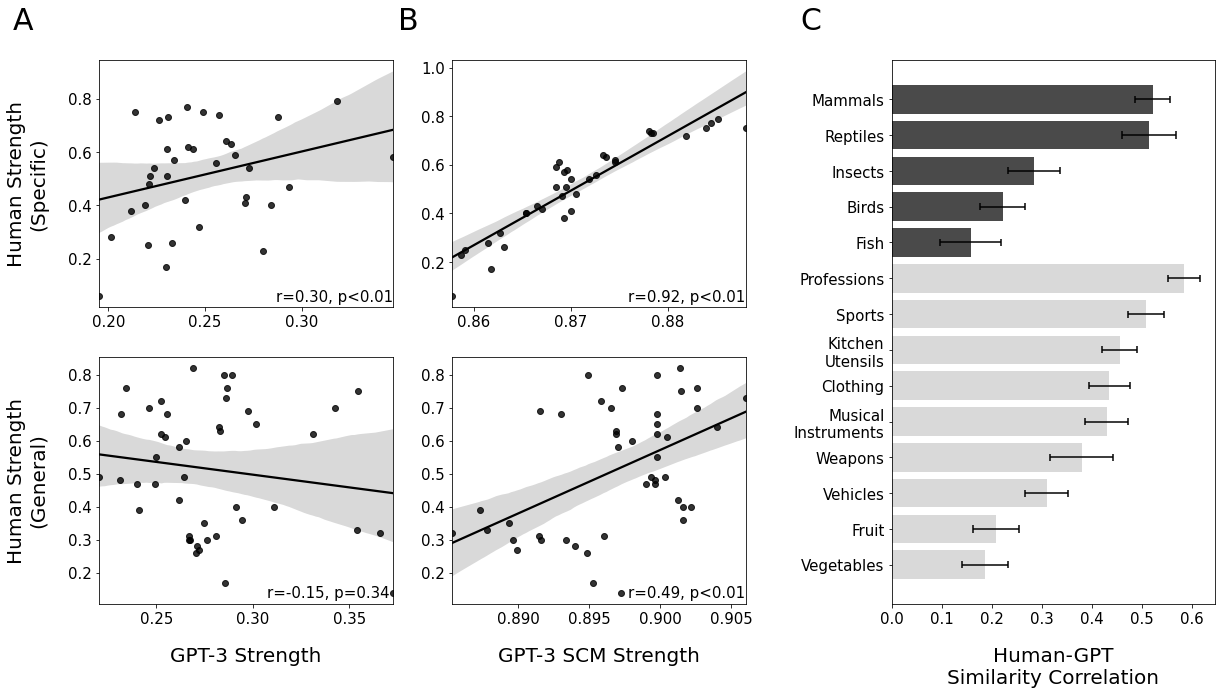

In [190]:
fig = plt.figure(figsize=(20,10))

gs0 = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[2,1], wspace=0.3)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0])

ax1 = fig.add_subplot(gs00[0,0])
ax2 = fig.add_subplot(gs00[0,1])
ax3 = fig.add_subplot(gs00[1,0])
ax4 = fig.add_subplot(gs00[1,1])

ax5 = fig.add_subplot(gs0[1])


# Plot argument correlations
sns.regplot(y=specific_human_strength_df["human strength"], x=specific_df["yes_prob"], ax=ax1, scatter_kws={"color": "black"}, line_kws={"color": "black"})
sns.regplot(y="human strength", x="gpt maxsim scm", data=specific_human_strength_df, ax=ax2, scatter_kws={"color": "black"}, line_kws={"color": "black"})

sns.regplot(y=general_human_strength_df["human strength"], x=general_df["yes_prob"], ax=ax3, scatter_kws={"color": "black"}, line_kws={"color": "black"})
sns.regplot(y="human strength", x="gpt maxsim scm", data=general_human_strength_df, ax=ax4, scatter_kws={"color": "black"}, line_kws={"color": "black"})

ax1.set_ylabel('Human Strength\n(Specific)', labelpad=20, fontsize=20)
ax3.set_ylabel('Human Strength\n(General)', labelpad=20, fontsize=20)

for ax in [ax1,ax2,ax3,ax4]:
    plt.setp(ax.get_xticklabels(), fontsize=10)
    plt.setp(ax.get_yticklabels(), fontsize=10)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('GPT-3 Strength', labelpad=20, fontsize=20)
ax4.set_xlabel('GPT-3 SCM Strength', labelpad=20, fontsize=20)
ax2.set_ylabel('')
ax4.set_ylabel('')


r, p = stats.pearsonr(specific_df["yes_prob"], specific_human_strength_df["human strength"])
ax1.text(.6, .025, 'r={:.2f}, p<0.01'.format(r, p), fontsize=15, transform=ax1.transAxes)
#ax1.text(.8, .025, 'r={:.2f}'.format(r), fontsize=15, transform=ax1.transAxes)
ax1.xaxis.set_ticks(np.arange(0.2, 0.34, 0.05))
r, p = stats.pearsonr(specific_human_strength_df["human strength"], specific_human_strength_df["gpt maxsim scm"])
ax2.text(.6, .025, 'r={:.2f}, p<0.01'.format(r), fontsize=15, transform=ax2.transAxes)
#ax2.text(.8, .025, 'r={:.2f}'.format(r), fontsize=15, transform=ax2.transAxes)
ax2.xaxis.set_ticks(np.arange(0.86, 0.88, 0.01))

r, p = stats.pearsonr(general_df["yes_prob"], general_human_strength_df["human strength"])
ax3.text(0.57, .025, 'r={:.2f}, p={:.2g}'.format(r, p), fontsize=15, transform=ax3.transAxes)
#ax3.text(0.775, .025, 'r={:.2f}'.format(r), fontsize=15, transform=ax3.transAxes)
ax3.xaxis.set_ticks(np.arange(0.25, 0.36, 0.05))
r, p = stats.pearsonr(general_human_strength_df["human strength"], general_human_strength_df["gpt maxsim scm"])
ax4.text(.6, .025, 'r={:.2f}, p<0.01'.format(r), fontsize=15, transform=ax4.transAxes)
# ax4.text(.8, .025, 'r={:.2f}'.format(r), fontsize=15, transform=ax4.transAxes)
ax4.xaxis.set_ticks(np.arange(0.89, 0.905, 0.005))

# Plot similarity correlations
bp = sns.barplot(y="Category", x="Correlation", palette=["#4a4a4a"]*animal_correlation_df.shape[0] + ["#d9d9d9"]*other_correlation_df.shape[0], data=correlation_df, ax=ax5)
# Add error bars
for i, row in correlation_df.reset_index(drop=True).iterrows():
    bp.errorbar(x=row["Correlation"],y=i,xerr=row["Standard Error"], ecolor="black") 
    bp.errorbar(x=row["Correlation"] - row["Standard Error"], y=i, yerr=0.1, ecolor="black")
    bp.errorbar(x=row["Correlation"] + row["Standard Error"], y=i, yerr=0.1, ecolor="black")
#ax5.invert_xaxis()
ax5.set_xlabel("Human-GPT\nSimilarity Correlation", labelpad=20, fontsize=20)
ax5.set_ylabel("", labelpad=30, fontsize=20)

for ax in (ax1, ax2, ax3, ax4, ax5):
    plt.setp(ax.get_yticklabels(), fontsize=15)
    plt.setp(ax.get_xticklabels(), fontsize=15)

ax1.set_title("A", x=-0.26, y=1.1, fontsize=30)
ax2.set_title("B", x=-0.15, y=1.1, fontsize=30)
ax5.set_title("C", x=-0.25, y=1.045, fontsize=30)

plt.savefig("figure2.png", dpi=600)

# Fig 3: Argument strength correlations over models

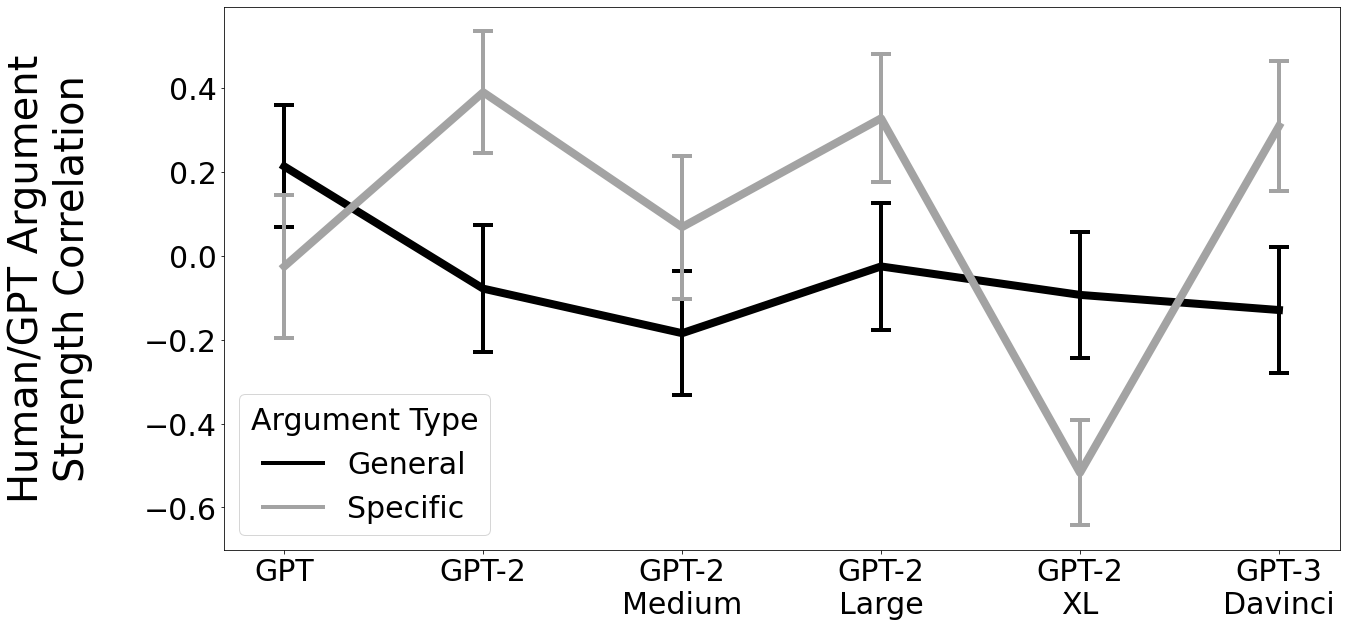

In [194]:
df = pd.read_csv("../gpt_human_mammal_similarities.csv", index_col=0)

model_order = {
    "gpt": 1,
    "gpt2": 2,
    "gpt2-medium": 3,
    "gpt2-large": 4,
    "gpt2-xl": 5,
    "gpt3-davinci": 6
}

RENAME = {
    "gpt": "GPT",
    "gpt2": "GPT-2",
    "gpt2-medium": "GPT-2\nMedium",
    "gpt2-large": "GPT-2\nLarge",
    "gpt2-xl": "GPT-2\nXL",
    "gpt3-davinci": "GPT-3\nDavinci"
}

# Get GPT/human argument strength correlations
old_df = pd.read_csv("../figure_3_argument_data.csv", index_col=0)
specific_gpt3_df, specific_human_strength_df = get_human_strength_df("specific")
general_gpt3_df, general_human_strength_df = get_human_strength_df("general")

human_strengths = {"specific": specific_human_strength_df, "general": general_human_strength_df}
gpt3_strengths = {"specific": specific_gpt3_df, "general": general_gpt3_df}

rows = []
for m_ct, tdf in old_df.groupby(["model", "conclusion_type"]):
    model, conclusion_type = m_ct
    r, p = stats.pearsonr(human_strengths[conclusion_type]["human strength"], tdf["yes_prob"])
    se = (1 - r*r)/np.sqrt(tdf.shape[0] - 2)
    rows.append((model, conclusion_type.capitalize(), r, p, se))

for conclusion_type in human_strengths:
    r, p = stats.pearsonr(human_strengths[conclusion_type]["human strength"], gpt3_strengths[conclusion_type]["yes_prob"])
    se = (1 - r*r)/np.sqrt(gpt3_strengths[conclusion_type].shape[0] - 2)
    rows.append(("gpt3-davinci", conclusion_type.capitalize(), r, p, se))
    
argument_correlation_df = pd.DataFrame(rows, columns=["model", "Argument Type", "human/model\ncorrelation strength", "p", "se"])
argument_correlation_df["model_order"] = argument_correlation_df["model"].apply(lambda x: model_order[x])
argument_correlation_df["model"] = argument_correlation_df["model"].apply(lambda x: RENAME[x])

fig, ax = plt.subplots(figsize=(20,10))
lp = sns.lineplot(x="model", y="human/model\ncorrelation strength", hue="Argument Type", data=argument_correlation_df.sort_values(by="model_order"), palette=["#000000", "#a3a3a3"], linewidth=8)

# Error bars
for model_name, model_num in model_order.items():
    i = model_num - 1
    general_row = argument_correlation_df[(argument_correlation_df["Argument Type"] == "General") & (argument_correlation_df["model"] == RENAME[model_name])]
    specific_row = argument_correlation_df[(argument_correlation_df["Argument Type"] == "Specific") & (argument_correlation_df["model"] == RENAME[model_name])]
    
    lp.errorbar(x=i,y=general_row["human/model\ncorrelation strength"].iloc[0],yerr=general_row["se"], ecolor="#000000", elinewidth=4)
    lp.errorbar(x=i, y=general_row["human/model\ncorrelation strength"].iloc[0]-general_row["se"], xerr=0.05, ecolor="#000000", elinewidth=4)
    lp.errorbar(x=i, y=general_row["human/model\ncorrelation strength"].iloc[0]+general_row["se"], xerr=0.05, ecolor="#000000", elinewidth=4)

    lp.errorbar(x=i,y=specific_row["human/model\ncorrelation strength"].iloc[0],yerr=specific_row["se"], ecolor="#a3a3a3", elinewidth=4)
    lp.errorbar(x=i, y=specific_row["human/model\ncorrelation strength"].iloc[0]-specific_row["se"], xerr=0.05, ecolor="#a3a3a3", elinewidth=4)
    lp.errorbar(x=i, y=specific_row["human/model\ncorrelation strength"].iloc[0]+specific_row["se"], xerr=0.05, ecolor="#a3a3a3", elinewidth=4)
    
#ax.set_xlabel("\nGPT Variant", fontsize=40)
ax.set_xlabel("", fontsize=40)
ax.set_ylabel("Human/GPT Argument\nStrength Correlation\n", fontsize=40)

plt.setp(ax.get_yticklabels(), fontsize=30)
plt.setp(ax.get_xticklabels(), fontsize=30)

leg = plt.legend(fontsize=30, title="Argument Type", title_fontsize=30)
for line in leg.get_lines():
    line.set_linewidth(4)
    
plt.savefig("fig3.png", dpi=600)

In [138]:
gpt_old_embedding_df = pd.read_csv("../figure_3_scm_data.csv", index_col=0)
gpt_old_embedding_df["embedding"] = gpt_old_embedding_df["embedding"].apply(eval)
embedding_map = {model: {hl: {row["category"]: row["embedding"] for _, row in hdf.iterrows()} for hl, hdf in mdf.groupby("hidden_layer")} for model, mdf in gpt_old_embedding_df.groupby("model")}

In [110]:
_, specific_human_strength_df = get_human_strength_df("specific")
_, general_human_strength_df = get_human_strength_df("general")

rows = []
for model, mdf in gpt_old_embedding_df.groupby("model"):
    
    max_specific_r = 0
    max_specific_p = 0
    max_specific_hl = 0
    max_general_r = 0
    max_general_p = 0
    max_general_hl = 0
    
    for hl, hdf in mdf.groupby("hidden_layer"):
        
        specific_scm_values = [scm(row["premise_1"], row["premise_2"], "", row["conclusion"], embedding_map[model][hl]) for _, row in specific_human_strength_df.iterrows()]
        general_scm_values = [scm(row["premise_1"], row["premise_2"], row["premise_3"], "mammal", embedding_map[model][hl]) for _, row in general_human_strength_df.iterrows()]
        
        specific_r, specific_p = stats.pearsonr(specific_scm_values, specific_human_strength_df["human strength"].tolist())
        general_r, general_p = stats.pearsonr(general_scm_values, general_human_strength_df["human strength"].tolist())
        
        if specific_r > max_specific_r:
            max_specific_r = specific_r
            max_specific_p = specific_p
            max_specific_hl = hl
        if general_r > max_general_r:
            max_general_r = general_r
            max_general_p = general_p
            max_general_hl = hl
            
    rows.append((model, max_specific_r, max_specific_p, max_specific_hl, max_general_r, max_general_p, max_general_hl))

In [111]:
rs, ps = stats.pearsonr(specific_human_strength_df["human strength"], specific_human_strength_df["gpt maxsim scm"])
rg, pg = stats.pearsonr(general_human_strength_df["human strength"], general_human_strength_df["gpt maxsim scm"])
rows.append(("gpt3-davinci", rs, ps, -1, rg, pg, -1))

gpt_old_correlations = pd.DataFrame(rows, columns=["model", "max_specific_r", "max_specific_p", "max_specific_hl", "max_general_r", "max_general_p", "max_general_hl"])

scm_correlation_df = pd.melt(gpt_old_correlations[["model", "max_specific_r", "max_general_r"]], id_vars="model", value_vars=["max_specific_r", "max_general_r"], var_name="Argument Type", value_name="human/model\ncorrelation strength")
scm_correlation_df["Argument Type"] = scm_correlation_df["Argument Type"].apply(lambda x: "Specific" if "specific" in x else "General")
scm_correlation_df["model_order"] = scm_correlation_df["model"].apply(lambda x: model_order[x])
scm_correlation_df["model"] = scm_correlation_df["model"].apply(lambda x: RENAME[x])


TypeError: A single argument passed to legend() must be a list of labels, but found an Artist in there.

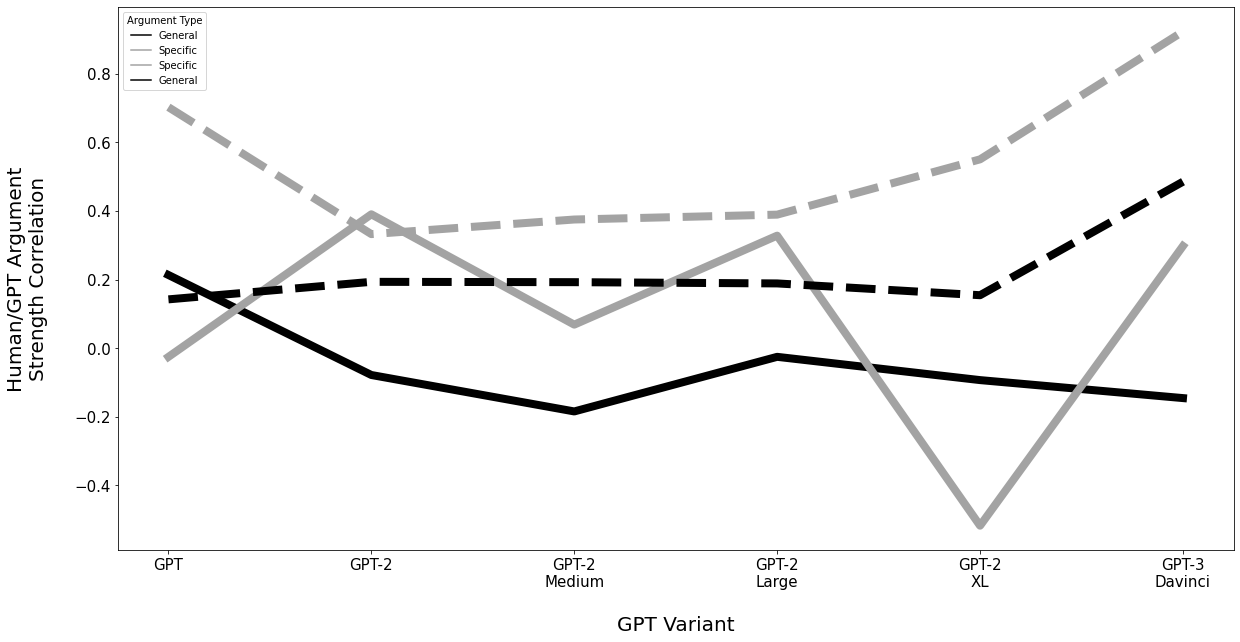

In [112]:
fig, ax = plt.subplots(figsize=(20,10))
lp1 = sns.lineplot(x="model", y="human/model\ncorrelation strength", hue="Argument Type", data=argument_correlation_df.sort_values(by="model_order"), palette=["#000000", "#a3a3a3"], linewidth=8, ax=ax)
lp2 = sns.lineplot(x="model", y="human/model\ncorrelation strength", hue="Argument Type", data=scm_correlation_df.sort_values(by="model_order"), linestyle='--', palette=["#a3a3a3", "#000000"], linewidth=8, ax=ax)

ax.set_xlabel("\nGPT Variant", fontsize=20)
ax.set_ylabel("Human/GPT Argument\nStrength Correlation\n", fontsize=20)

plt.setp(ax.get_yticklabels(), fontsize=15)
plt.setp(ax.get_xticklabels(), fontsize=15)

# leg = plt.legend(fontsize=20, title="Argument Type", title_fontsize=20)
# for line in leg.get_lines():
#     line.set_linewidth(4)
    
ax.legend([lp1.lines[0], lp1.lines[1], lp2.lines[0], lp2.lines[1]])#, ['Human/Osherson', 'GPT-3/Osherson', 'GPT-3/Generated'], title="Agent/Dataset", title_fontsize=20, fontsize=20)

In [156]:
gpt_old_sim_df = pd.read_csv("../gpt_human_category_similarities.csv", index_col=0)

model_category_correlations = {m: {} for m in gpt_old_sim["model"].unique()}
for mc, tdf in gpt_old_sim_df.groupby(["model", "category_class"]):
    model, category_class = mc
#     hr = 0
#     hp = 0
#     hhl = 0
#     for hl, hl_df in tdf.groupby("hidden_state_layer"):
#         r, p = stats.pearsonr(hl_df["gpt_distance"].tolist(), hl_df["human_similarity"].tolist())
#         if abs(r) > hr:
#             hr = r
#             hp = p
#             hhl = hl
#     model_category_correlations[model][category_class] = (hr,hp,hhl)

    hhl = np.max(tdf["hidden_state_layer"])
    hl_df = tdf[tdf["hidden_state_layer"] == hhl]
    r, p = stats.pearsonr(hl_df["gpt_distance"].tolist(), hl_df["human_similarity"].tolist())
    model_category_correlations[model][category_class] = (r,p,hhl)

gpt -0.02693711218838238
gpt2 -0.0007389121871454532
gpt2-medium 0.02030861130208334
gpt2-large -0.09264723569435664
gpt2-xl -0.08404390961479445


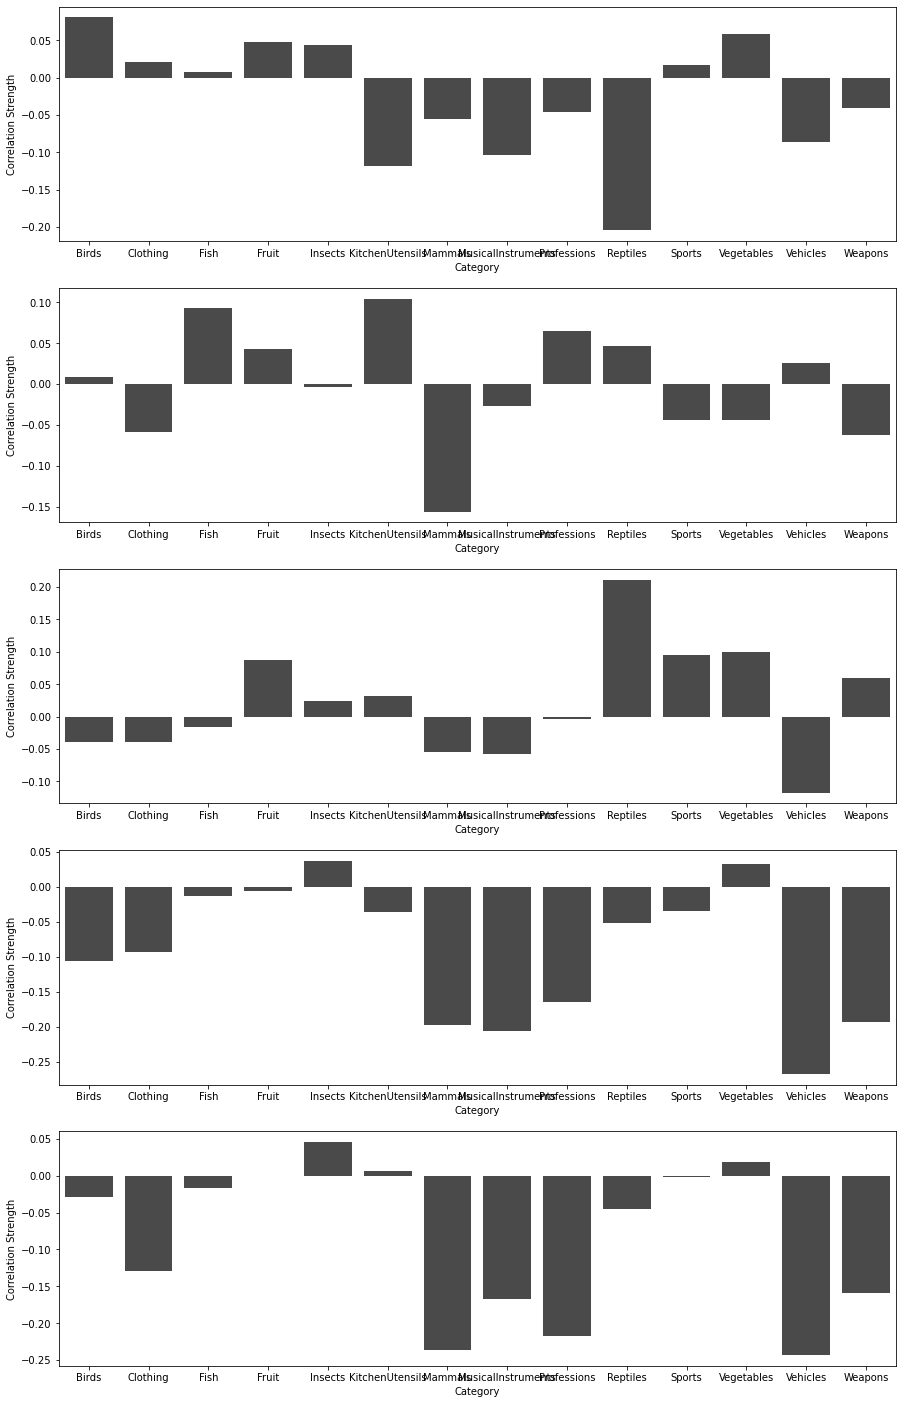

In [181]:
fig, axes = plt.subplots(len(model_category_correlations), 1, figsize=(15,25))
for i, model in enumerate(model_category_correlations):
    rows = [[a]+list(b) for a,b in model_category_correlations[model].items()]
    cdf = pd.DataFrame(rows, columns=["Category", "Correlation Strength", "p", "hidden layer"])
    print(model, np.mean(cdf["Correlation Strength"]))
    sns.barplot(x="Category", y="Correlation Strength", color="#4a4a4a", data=cdf, ax=axes[i])

In [164]:
[[a+list(b)] for a,b in model_category_correlations["gpt"].items()]

ValueError: not enough values to unpack (expected 2, got 1)

In [170]:
[a for a in zip(list(model_category_correlations["gpt"].items()))]

[(('Birds', (0.08087801027840905, 0.0920364540736016, 12)),),
 (('Clothing', (0.02128134710897063, 0.6689907234181546, 12)),),
 (('Fish', (0.0074456291232139725, 0.9061903531820765, 12)),),
 (('Fruit', (0.04820244284549473, 0.3158453972250209, 12)),),
 (('Insects', (0.043664297376146445, 0.4327405624340339, 12)),),
 (('KitchenUtensils', (-0.11860505559619275, 0.00636203069677111, 12)),),
 (('Mammals', (-0.05487199518454878, 0.2534483021369511, 12)),),
 (('MusicalInstruments', (-0.1039501051884256, 0.051674917402116924, 12)),),
 (('Professions', (-0.045916087981296316, 0.33937323733564284, 12)),),
 (('Reptiles', (-0.20473449126170384, 0.004603772843658288, 12)),),
 (('Sports', (0.01740451071965593, 0.7173648936737137, 12)),),
 (('Vegetables', (0.05902464515011266, 0.21922716528211708, 12)),),
 (('Vehicles', (-0.08576122615288899, 0.07396356057840191, 12)),),
 (('Weapons', (-0.04118149187430044, 0.5726580324339839, 12)),)]